In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


In [2]:
from data.codet_m4 import CoDeTM4
train, val, test  = CoDeTM4('../../data/').get_dataset(['train','val','test'], columns='all', dynamic_split_sizing=False)

In [3]:
from datasets import concatenate_datasets

In [4]:
codet = concatenate_datasets([train, val, test])

In [5]:
import tree_sitter_python as tspython
import tree_sitter_cpp as tscpp
import tree_sitter_java as tsjava
from tree_sitter import Parser, Language

TS_PYTHON = Language(tspython.language())
TS_JAVA = Language(tsjava.language())
TS_CPP = Language(tscpp.language())

PYTHON_PARSER, JAVA_PARSER, CPP_PARSER = Parser(language=TS_PYTHON), Parser(language=TS_JAVA), Parser(language=TS_CPP)

In [6]:
import re

TOKEN_REGEX = re.compile(r'''
    # --- STRING LITERALS ---
    ("(?:\\.|[^"\\])*" | '(?:\\.|[^'\\])*') |

    # --- COMMENTS (Python/Java/C++) ---
    (//[^\n]* | \#[^\n]* | /\*.*?\*/ ) |

    # --- OPERATORS & SYMBOLS ---
    (\+\+|--|==|!=|<=|>=|&&|\|\||::|->|[=+\-*/%<>!&|^~?:;.,()[\]{}]) |

    # --- NUMBERS ---
    (\b\d+(?:\.\d+)?\b) |

    # --- IDENTIFIERS / VARIABLES / KEYWORDS ---
    (\b[a-zA-Z_]\w*\b)
''', re.VERBOSE | re.DOTALL)

def tokenize_code(code):
    tokens = []
    for match in TOKEN_REGEX.finditer(code):
        token = match.group(0)
        tokens.append(token)
    return tokens

In [7]:
import matplotlib.pyplot as plt

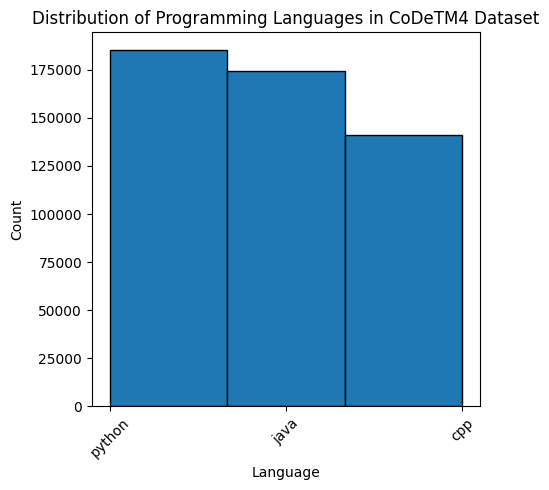

Python count: 185163
Java count: 174169
C++ count: 141220


In [8]:
language_counts = codet['language']
plt.figure(figsize=(5, 5))
plt.hist(language_counts, bins=len(set(language_counts)), edgecolor='black')
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Programming Languages in CoDeTM4 Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

python_count = language_counts.count("python")
java_count = language_counts.count("java")
cpp_count = language_counts.count("cpp")

print(f'Python count: {python_count}')
print(f'Java count: {java_count}')
print(f'C++ count: {cpp_count}')

In [9]:
from itertools import islice

vectorizer_samples = list(
    islice(
        (sample for sample in codet if sample['language'] == 'python'),
        int(0.1*python_count)
    )
)

vectorizer_samples.extend(
    list(
        islice(
            (sample for sample in codet if sample['language'] == 'java'),
            int(0.1*java_count)
        )
    )
)
vectorizer_samples.extend(
    list(
        islice(
            (sample for sample in codet if sample['language'] == 'cpp'),
            int(0.1*cpp_count)
        )
    )
)

In [10]:
len(vectorizer_samples) == int(0.1*python_count) + int(0.1*java_count) + int(0.1*cpp_count)

True

In [11]:
def get_parser(language):
    match language:
        case 'python':
            return PYTHON_PARSER
        case 'java':
            return JAVA_PARSER
        case 'cpp':
            return CPP_PARSER
    raise ValueError(f"Unsupported language: {language}")

In [12]:
def create_tree(sample, code_key='cleaned_code'):
    language = sample['language']
    parser = get_parser(language)
    tree = parser.parse(bytes(sample[code_key], 'utf-8'))
    return tree

In [13]:
tree = create_tree(codet[0])

In [14]:
tree.walk()

In [15]:
from tree_sitter import TreeCursor

def walk_tree(cursor: TreeCursor, depth=0):
    indent = '  ' * depth
    print(f"{indent}{cursor.node.type}")

    if cursor.goto_first_child():
        walk_tree(cursor, depth+1)
    
        while cursor.goto_next_sibling():
            walk_tree(cursor, depth+1)

        cursor.goto_parent()

cursor = tree.walk()
walk_tree(cursor)

module
  function_definition
    def
    identifier
    parameters
      (
      identifier
      ,
      identifier
      ,
      identifier
      ,
      identifier
      )
    :
    block
      expression_statement
        assignment
          identifier
          =
          unary_operator
            -
            float
      expression_statement
        assignment
          identifier
          =
          float
      expression_statement
        assignment
          identifier
          =
          unary_operator
            -
            float
      for_statement
        for
        identifier
        in
        identifier
        :
        block
          if_statement
            if
            comparison_operator
              subscript
                identifier
                [
                integer
                ]
              >
              identifier
            :
            block
              expression_statement
                assignment
                  ide

In [16]:
from typing import Set

def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
    if types is None:
        types = set()
    
    types.add(cursor.node.type)

    if cursor.goto_first_child():
        get_node_types_from_tree(cursor, types)
    
        while cursor.goto_next_sibling():
            get_node_types_from_tree(cursor, types)

        cursor.goto_parent()

    return types

In [17]:
cursor = tree.walk()
types = get_node_types_from_tree(cursor)

In [18]:
len(types)

68

In [19]:
def extract_types(sample):
    parser = get_parser(sample['language'])
    tree = parser.parse(sample['cleaned_code'].encode('utf-8'))
    cursor = tree.walk()
    types = get_node_types_from_tree(cursor)
    return {"types": list(types)}

result = codet.map(extract_types, batched=False, num_proc=8)

all_types = set()
for tlist in result['types']:
    all_types.update(tlist)

print(f"Collected {len(all_types)} unique node types")

Parameter 'function'=<function extract_types at 0x7fa6e8ee70a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
2025-07-25 03:32:10,074 - WARNING - Parameter 'function'=<function extract_types at 0x7fa6e8ee70a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute

Map (num_proc=8):   0%|          | 0/500552 [00:00<?, ? examples/s]

Collected 563 unique node types


In [20]:
all_types = sorted(list(all_types))

In [21]:
type_to_ind = {t: i for i, t in enumerate(all_types)}

In [22]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
from tree_sitter import Node

In [23]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
import torch
from tree_sitter import TreeCursor

def tree_to_graph(cursor: TreeCursor, id_map: Dict = None, next_id: int = 0, edges: List[Tuple[int, int]] = None) -> Tuple[List[Tuple[int, int]], Dict, int]:
    if edges is None:
        edges = []
    if id_map is None:
        id_map = {}

    # Assign ID to current node
    if cursor.node not in id_map:
        id_map[cursor.node] = next_id
        next_id += 1
    current_id = id_map[cursor.node]

    if cursor.goto_first_child():
        while True:
            if cursor.node not in id_map:
                id_map[cursor.node] = next_id
                next_id += 1
            child_id = id_map[cursor.node]
            edges.append((current_id, child_id))
            # Recurse
            edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
            if not cursor.goto_next_sibling():
                break
        cursor.goto_parent()  # restore parent position

    return edges, id_map, next_id

In [24]:
import h5py
from tqdm import tqdm

In [25]:
def create_graph(sample):
    tree = create_tree(sample)
    edges, id_map, _ = tree_to_graph(tree.walk())
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = [type_to_ind[node.type] for node, _ in sorted(id_map.items(), key=lambda kv: kv[1])]
    x = torch.tensor(x, dtype=torch.long)
    y = torch.tensor([sample['target_binary']], dtype=torch.long)
    data = Data(x=x, y=y, edge_index=edge_index)
    return data


In [26]:
data = create_graph(codet[0])

In [27]:
import torch
from torch_geometric.data import Data

train_graphs = []
val_graphs = []
test_graphs = []

for i, sample in enumerate(tqdm(codet, desc='Creating graphs')):
    data = create_graph(sample)

    if sample['split'] == 'train':
        train_graphs.append(data)
    elif sample['split'] == 'val':
        val_graphs.append(data)
    else:
        test_graphs.append(data)

Creating graphs: 100%|██████████| 500552/500552 [07:00<00:00, 1189.90it/s]


In [28]:
del train, val, test, codet

In [29]:
torch.save(train_graphs, '../../data/codet_graphs/train_graphs.pt')
torch.save(val_graphs, '../../data/codet_graphs/val_graphs.pt')
torch.save(test_graphs, '../../data/codet_graphs/test_graphs.pt')
torch.save(type_to_ind, '../../data/codet_graphs/type_to_ind.pt')

In [ ]:
# def safe_create_dataset(hf, dataset_name, data):
#     if dataset_name in hf:
#         del hf[dataset_name]
#     hf.create_dataset(dataset_name, data=data)

# checkpoint_file = '../../data/codet_graphs/graph_progress_nodetypes.txt'

# start_idx = 0 
# if os.path.exists(checkpoint_file):
#     with open(checkpoint_file, 'r') as f:
#         start_idx = int(f.read().strip()) + 1
#     print(f'Resuming from sample: {start_idx}')

    
# with h5py.File('../../data/codet_graphs/graphs_nodetypes.h5', 'a') as hf:
#     for i, sample in enumerate(start=start_idx, iterable=tqdm(codet.skip(start_idx), desc='Creating graphs', initial=start_idx)):
#         data = create_graph(sample)
#         dataset_name = f'{sample["split"]}/node_features/graph_{i:07d}'
#         safe_create_dataset(hf, dataset_name, data.x.numpy())

#         dataset_name = f'{sample["split"]}/edge_indices/graph_{i:07d}'
#         safe_create_dataset(hf, dataset_name, data.edge_index.numpy())

#         dataset_name = f'{sample["split"]}/labels/graph_{i:07d}'
#         safe_create_dataset(hf, dataset_name, data.y.numpy())

#         if i % 200 == 0:
#             with open(checkpoint_file, 'w') as f:
#                 f.write(str(i))


Creating graphs: 100%|██████████| 500552/500552 [54:19<00:00, 153.59it/s] 


In [ ]:
# import h5py
# import torch
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader

# class H5GraphDataset:
#     def __init__(self, h5_file_path, split='train'):
#         self.h5_file_path = h5_file_path
#         self.split = split
#         self.hf = h5py.File(h5_file_path, 'r')  # Open once and keep open
#         self.length = len(self.hf[split]['node_features'])

#     def __len__(self):
#         return self.length

#     def __getitem__(self, idx):
#         graph_key = f'graph_{idx:07d}'

#         x = torch.from_numpy(self.hf[self.split]['node_features'][graph_key][:])
#         edge_index = torch.from_numpy(self.hf[self.split]['edge_indices'][graph_key][:])
#         y = torch.from_numpy(self.hf[self.split]['labels'][graph_key][:])

#         return Data(x=x, edge_index=edge_index, y=y)

#     def __del__(self):
#         if hasattr(self, 'hf') and self.hf:
#             self.hf.close()

# # Usage
# train_dataset = H5GraphDataset('../../data/codet_graphs/graphs_nodetypes.h5', split='train')
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Example training loop
# i=0
# for batch in train_loader:
#     # batch.x, batch.edge_index, batch.y are ready for your model
#     i+=32
#     if i >= 10000:
#         print(f"Batch size: {batch.num_graphs}, Node features shape: {batch[0].x.shape}")

#         break  # Just showing the first batch



KeyboardInterrupt: 

In [ ]:
# del train_loader, train_dataset

In [ ]:
# import h5py
# import torch
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader

# class InMemoryGraphDataset(torch.utils.data.Dataset):
#     def __init__(self, h5_file_path, split='train'):
#         self.graphs = []

#         with h5py.File(h5_file_path, 'r') as hf:
#             node_feats = hf[split]['node_features']
#             edge_inds = hf[split]['edge_indices']
#             labels = hf[split]['labels']

#             for graph_key in node_feats:
#                 x = torch.from_numpy(node_feats[graph_key][:])
#                 edge_index = torch.from_numpy(edge_inds[graph_key][:])
#                 y = torch.from_numpy(labels[graph_key][:])

#                 self.graphs.append(Data(x=x, edge_index=edge_index, y=y))

#     def __len__(self):
#         return len(self.graphs)

#     def __getitem__(self, idx):
#         return self.graphs[idx]


In [ ]:
# train_dataset = InMemoryGraphDataset('../../data/codet_graphs/graphs_nodetypes.h5', split='train')
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# i=0
# for batch in train_loader:
#     # batch.x, batch.edge_index, batch.y are ready for your model
#     i+=32
#     if i >= 10000:
#         print(f"Batch size: {batch.num_graphs}, Node features shape: {batch[0].x.shape}")

#         break  # Just showing the first batch